# Tema - Sistema de Gestão de Barragens de Mineração (SIGBM) - Agência Nacional de Mineração (ANM)

# - Descrição dos dados
## Fonte dos Dados
- **URL**: https://dados.gov.br/dados/conjuntos-dados/barragens-de-mineracao
- https://dashboard-barragens-7jzga8vsbojhztn4xkhaxj.streamlit.app/
- **Domínio**: gov.br

## Descrição do Dataset
O dataset `Barragens.csv` contém informações detalhadas sobre barragens de mineração cadastradas no SIGBM, incluindo:

- **Identificação**: ID, Nome, Empreendedor, CPF/CNPJ
- **Localização**: UF, Município, Latitude, Longitude
- **Características Técnicas**: Altura, Volume, Tipo de construção
- **Segurança**: Categoria de risco, Dano potencial, Nível de emergência
- **Operação**: Status operacional, datas de construção e operação
- **Materiais**: Minério, produtos químicos utilizados


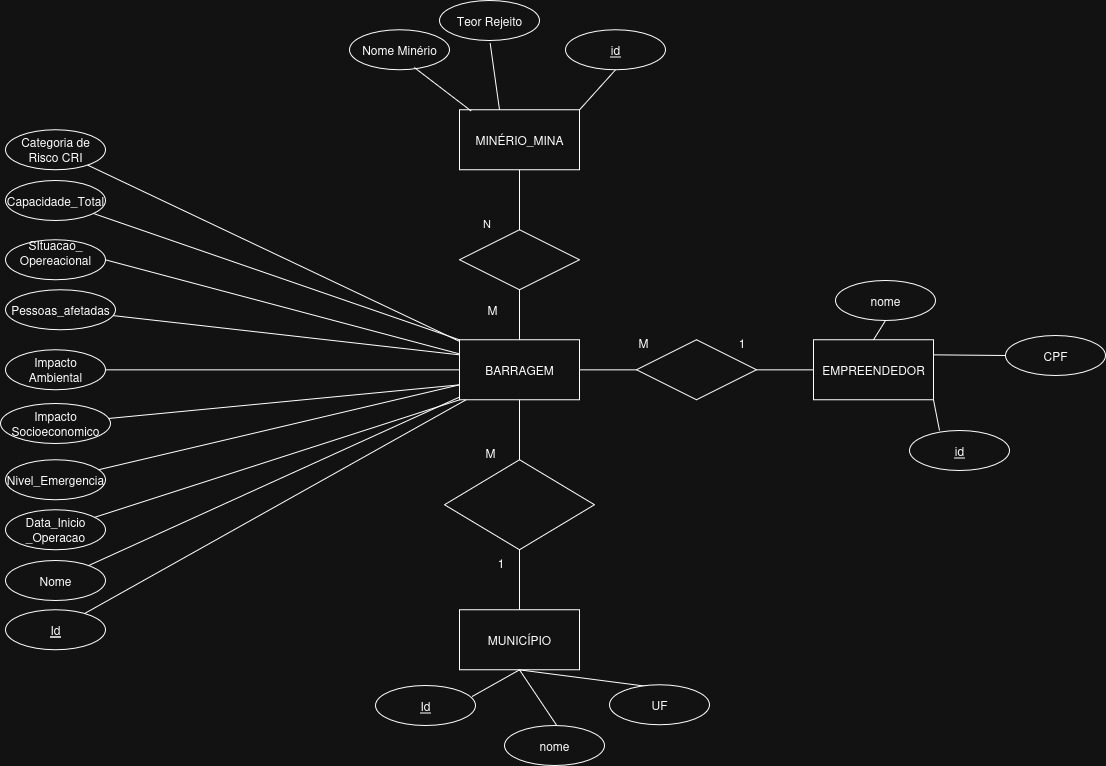

# Diagrama relacional
BARRAGEM(Id, Nome, Capacidade_Total, Situacao_Operacional, Data_Inicio_Operacao, Categoria_Risco_CRI, Pessoas_afetadas, ImpactoAmbiental, Impacto_Socioeconomico, Nivel_Emergencia, id_Municipio, id_Empreendedor)
id_Municipio referencia MUNICÍPIO id_Empreendedor referencia EMPREENDEDOR

MUNICÍPIO(Id, nome, UF)

EMPREENDEDOR(Id, nome, CPF)

MINERIO(Id, Nome, Teor_Rejeito)

BARRAGEM_MINERIO(id_barragem, id_minerio, Teor_Rejeito)
id_barragem referencia BARRAGEM id_minerio referencia MINERIO

# Processamento e Inserção dos dados

In [ ]:
### Importações e Funções Auxiliares
import csv
import pandas as pd
import sqlite3

import requests
from PIL import Image
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def fetch(query, conn, formatted=True):
    # execute the query and fetch all rows
    cur = conn.cursor()
    cur.execute(query)
    rs = cur.fetchall()

    # extract column names from the cursor description
    columns = [desc[0] for desc in cur.description]

    # return a dataframe with column names
    return pd.DataFrame(rs, columns=columns) if formatted else rs

def show_tables(conn):
    return [x[0] for x in fetch('SELECT tbl_name FROM sqlite_master WHERE type="table"', conn, False)]

def shape(table, conn):
    nrows = fetch(f'SELECT COUNT(*) FROM {table}', conn, False)[0][0]
    ncols = fetch(f'SELECT COUNT(*) FROM pragma_table_info("{table}")', conn, False)[0][0]

    return (nrows, ncols)

def desc(table, conn):
    cur = conn.cursor()
    cur.execute(f'PRAGMA table_info("{table}")')
    columns = [row[1] for row in cur.fetchall()]

    return columns

def info(table, conn):
    # table constraints (domain, null, default, pk)
    df1 = fetch(f'PRAGMA table_info("{table}")', conn)
    columns = desc(table, conn)

    # entries per column
    counts = ', '.join([f'COUNT(*) AS "{column}"' for column in columns])
    df2 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df2.columns = ['count']

    # non-null entries per column
    counts = ', '.join([f'COUNT("{column}") AS "{column}"' for column in columns])
    df3 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df3.columns = ['notnull count']

    # unique non-null entries per column
    counts = ', '.join([f'COUNT(DISTINCT "{column}") AS "{column}"' for column in columns])
    df4 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df4.columns = ['unique count']

    return df1.merge(df2, left_on='name', right_index=True) \
            .merge(df3, left_on='name', right_index=True) \
            .merge(df4, left_on='name', right_index=True)

def display(urls, cols=5):
    # fetch images
    images = []
    for url in urls:
        response = requests.get(url)
        if response.status_code == 200:
            images.append(Image.open(BytesIO(response.content)))

    # calculate the number of rows
    rows = (len(images) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    for i, ax in enumerate(axs.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis("off")  # Hide axes
        else:
            ax.axis("off")  # Hide unused subplots
    plt.tight_layout()
    plt.show()

def hist(data, xlabel='', ylabel='', bins='auto'):
    # convert list of tuples into dataframe
    df = pd.DataFrame(data, columns=['key', 'frequency'])
    # expand the data based on frequencies
    expanded = df.loc[df.index.repeat(df['frequency'])].reset_index(drop=True)

    # plot histogram
    sns.histplot(expanded['key'], bins=bins, kde=False)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.show()

## Inserção dos Dados

In [ ]:
# source dataset: https://www.kaggle.com/datasets/amanbarthwal/imdb-movies-data
source = '/content/drive/MyDrive/TP2_IBD/Barragens.csv'

# connect to SQLite database
conn = sqlite3.connect('barragens.db')
cur = conn.cursor()

# set PRAGMA options for faster ingestion
cur.execute('PRAGMA synchronous = OFF')
cur.execute('PRAGMA journal_mode = MEMORY')

# batch size for processing large datasets
BATCH_SIZE = 1000

# begin transaction for bulk ingestion
cur.execute('BEGIN TRANSACTION')

# read the CSV file and ingest in batches
with open(source, 'r', encoding='latin-1') as f:
    reader = csv.reader(f)
    print(f)
    header = next(reader)  # Read the header row

    # create table with appropriate column names
    columns = [f'"{column}"' for column in header]
    create = f'CREATE TABLE IF NOT EXISTS Source ({", ".join(columns)})'
    cur.execute(create)

    # prepare the INSERT query
    placeholders = ', '.join(['?'] * len(header))
    insert = f'INSERT INTO Source VALUES ({placeholders})'

    # process rows in batches
    batch = []
    for row in reader:
        batch.append(row)
        if len(batch) == BATCH_SIZE:
            # Execute batch insert
            cur.executemany(insert, batch)
            # Reset batch
            batch = []

    # insert any remaining rows
    if batch:
        cur.executemany(insert, batch)

# nullify empty values, so they are recognized as proper nulls
update = f'UPDATE Source SET ' + ','.join([f'{column} = NULLIF({column}, "")' for column in columns])
cur.execute(update)

# commit changes
conn.commit()

# reset PRAGMA options (optional but recommended for safety)
cur.execute('PRAGMA synchronous = FULL')
cur.execute('PRAGMA journal_mode = DELETE')

<_io.TextIOWrapper name='/content/drive/MyDrive/TP2_IBD/Barragens.csv' mode='r' encoding='latin-1'>


## Processamento dos Dados

In [ ]:
import sqlite3

# --- 1. CONEXÃO COM O BANCO DE DADOS ---
# Inicializa as variáveis de conexão como None para um tratamento de erro seguro
conn = None
cur = None

try:
    # Conecta-se ao banco de dados
    conn = sqlite3.connect('barragens.db')
    cur = conn.cursor()

    # Habilita o suporte a chaves estrangeiras para garantir a integridade dos dados
    cur.execute('PRAGMA foreign_keys = ON;')


    # --- 2. CRIAÇÃO E POPULAÇÃO DAS TABELAS ---
    # O script usa "CREATE TABLE IF NOT EXISTS" e "INSERT OR IGNORE"
    # para que possa ser executado múltiplas vezes sem erros.

    # Tabela MUNICÍPIO
    cur.execute('''
        CREATE TABLE IF NOT EXISTS MUNICÍPIO (
            Id INTEGER PRIMARY KEY,
            Nome TEXT NOT NULL,
            UF TEXT NOT NULL,
            UNIQUE(Nome, UF)
        );
    ''')
    cur.execute('''
        INSERT OR IGNORE INTO MUNICÍPIO (Nome, UF)
        SELECT DISTINCT
            "Município",
            "UF"
        FROM Source
        WHERE "Município" IS NOT NULL AND "UF" IS NOT NULL;
    ''')


    # Tabela EMPREENDEDOR
    cur.execute('''
        CREATE TABLE IF NOT EXISTS EMPREENDEDOR (
            Id INTEGER PRIMARY KEY,
            Nome TEXT,
            CPF TEXT UNIQUE NOT NULL
        );
    ''')
    cur.execute('''
        INSERT OR IGNORE INTO EMPREENDEDOR (Nome, CPF)
        SELECT
            MIN("Empreendedor"),
            "CPF_CNPJ"
        FROM Source
        WHERE "CPF_CNPJ" IS NOT NULL
        GROUP BY "CPF_CNPJ";
    ''')


    # Tabela BARRAGEM
    cur.execute('''
        CREATE TABLE IF NOT EXISTS BARRAGEM (
            Id INTEGER PRIMARY KEY,
            Nome TEXT,
            Capacidade_Total REAL,
            Situacao_Operacional TEXT,
            Categoria_Risco_CRI TEXT,
            Pessoas_afetadas INTEGER,
            ImpactoAmbiental TEXT,
            Impacto_Socioeconomico TEXT,
            Nivel_Emergencia TEXT,
            Data_Inicio_Operacao TEXT,
            id_Municipio INTEGER,
            id_Empreendedor INTEGER,
            FOREIGN KEY (id_Municipio) REFERENCES MUNICÍPIO(Id),
            FOREIGN KEY (id_Empreendedor) REFERENCES EMPREENDEDOR(Id)
        );
    ''')
    cur.execute('''
        INSERT OR IGNORE INTO BARRAGEM (
            Id, Nome, Capacidade_Total, Situacao_Operacional, Categoria_Risco_CRI,
            Pessoas_afetadas, ImpactoAmbiental, Impacto_Socioeconomico, Nivel_Emergencia,
            Data_Inicio_Operacao, id_Municipio, id_Empreendedor
        )
        SELECT
            s."ID",
            s."Nome",
            s."Capacidade Total do Reservatório (m³)",
            s."Situação Operacional",
            s."Categoria de Risco - CRI",
            s."Número de pessoas possivelmente afetadas a jusante em caso de rompimento da barragem",
            s."Impacto ambiental",
            s."Impacto sócio-econômico",
            s."Nível de Emergência",
            s."Data de Início de Operação",
            m.Id,
            e.Id
        FROM
            Source s
        LEFT JOIN MUNICÍPIO m ON s."Município" = m.Nome AND s."UF" = m.UF
        LEFT JOIN EMPREENDEDOR e ON s."CPF_CNPJ" = e.CPF;
    ''')


    # Tabela MINERIO
    cur.execute('''
        CREATE TABLE IF NOT EXISTS MINERIO (
            Id INTEGER PRIMARY KEY,
            Nome TEXT UNIQUE NOT NULL
        );
    ''')
    cur.execute('''
        INSERT OR IGNORE INTO MINERIO (Nome)
        SELECT DISTINCT "Minério principal presente no reservatório"
        FROM Source
        WHERE "Minério principal presente no reservatório" IS NOT NULL
          AND "Minério principal presente no reservatório" != '';
    ''')


    # Tabela BARRAGEM_MINERIO
    cur.execute('''
        CREATE TABLE IF NOT EXISTS BARRAGEM_MINERIO (
            id_barragem INTEGER NOT NULL,
            id_minerio INTEGER NOT NULL,
            Teor_Rejeito REAL,
            PRIMARY KEY (id_barragem, id_minerio),
            FOREIGN KEY (id_barragem) REFERENCES BARRAGEM(Id),
            FOREIGN KEY (id_minerio) REFERENCES MINERIO(Id)
        );
    ''')
    cur.execute('''
        INSERT OR IGNORE INTO BARRAGEM_MINERIO (id_barragem, id_minerio, Teor_Rejeito)
        SELECT
            s."ID",
            m.Id,
            s."Teor (%) do minério principal inserido no rejeito"
        FROM
            Source s
        JOIN MINERIO m ON s."Minério principal presente no reservatório" = m.Nome;
    ''')


    # --- 3. FINALIZAÇÃO ---
    conn.commit()
    print("Script executado com sucesso!")
    print("É seguro executar esta célula novamente.")

except Exception as e:
    print(f"Ocorreu um erro: {e}")
    if conn:
        conn.rollback()
finally:
    if cur:
        cur.close()
    if conn:
        conn.close()

Script executado com sucesso!
É seguro executar esta célula novamente.


## Entendendo os Dados

In [ ]:
# show tables
conn = sqlite3.connect('barragens.db')
show_tables(conn)

['Source',
 'MUNICÍPIO',
 'EMPREENDEDOR',
 'BARRAGEM',
 'MINERIO',
 'BARRAGEM_MINERIO']

In [ ]:
# get table shape -- analogous to pandas' shape
for table in show_tables(conn):
  print(table, shape(table, conn))


Source (1828, 123)
MUNICÍPIO (186, 3)
EMPREENDEDOR (295, 3)
BARRAGEM (914, 12)
MINERIO (51, 2)
BARRAGEM_MINERIO (564, 3)


In [ ]:
# info table -- analogous to pandas' .info() / .nunique()
info('Source', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,ID,,0,None,0,1828,1828,914
1,1,Nome,,0,None,0,1828,1828,872
2,2,Empreendedor,,0,None,0,1828,1828,295
3,3,CPF_CNPJ,,0,None,0,1828,1828,295
4,4,Nome da mina,,0,None,0,1828,680,174
...,...,...,...,...,...,...,...,...,...
118,118,Tipo de Back Up Dam quanto ao material de cons...,,0,None,0,1828,1828,3
119,119,Tipo de fundação da Back Up Dam,,0,None,0,1828,1828,3
120,120,Vazão de projeto da Back Up Dam,,0,None,0,1828,1828,2
121,121,Método construtivo da Back Up Dam,,0,None,0,1828,1828,2


In [ ]:
# peek into some data

# first rows -- analogous to pandas' head()
#fetch('SELECT * FROM Source ORDER BY "index" ASC LIMIT 2', conn)

# last rows -- analogous to pandas' tail()
#fetch('SELECT * FROM Source ORDER BY "index" DESC LIMIT 2', conn)

# random rows -- analogous to pandas' sample()
fetch('SELECT * FROM Source ORDER BY random() LIMIT 5', conn)

,ID,Nome,Empreendedor,CPF_CNPJ,Nome da mina,UF,Município,Latitude,Longitude,Posicionamento,...,Descarga Máxima do vertedouro da Back Up Dam (m³/seg),Existe documento que ateste a segurança estrutural e a capacidade para contenção de rejeitos da Back Up Dam com ART,Existe manual de operação da Back Up Dam,A Back up Dam passou por auditoria de terceira parte,A Back Up Dam garante a redução da área da mancha de inundação à jusante,Tipo de Back Up Dam quanto ao material de construção,Tipo de fundação da Back Up Dam,Vazão de projeto da Back Up Dam,Método construtivo da Back Up Dam,Tipo de auscultação da Back Up Dam
0,9765,Dique do Grotão,BURITIRAMA MINERACAO S.A. FALIDO,27121672000101,Mina de Buritirama,PA,MARABÁ,-05°30'32.687'',-50°14'00.427'',Sul do Equador,...,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem
1,9168,Gregório,LHG MINING CORUMBA S.A,03327988000196,Mina Santa Cruz,MS,CORUMBÁ,-19°13'28.008'',-57°33'35.925'',Sul do Equador,...,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem
2,9493,Barragem AFGM GP2,Valdinei Mauro de Souza,***568360***,None,MT,POCONÉ,-16°18'30.700'',-56°44'57.670'',Sul do Equador,...,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem
3,9629,6,VALE S.A.,33592510000154,Mina de Águas Claras,MG,NOVA LIMA,-19°57'36.000'',-43°52'58.000'',Sul do Equador,...,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem
4,9338,Pilha 05 - P5C2,MINERACAO CARAIBA S/A,42509257000113,None,BA,JAGUARARI,-09°52'42.688'',-39°52'02.408'',Sul do Equador,...,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem


# Consultas

## 1 - Ranking de Barragens Críticas por Idade, Risco e Impacto Populacional

In [ ]:
fetch('''SELECT
    m.Nome AS Municipio,
    b.Nome AS Nome_da_Barragem,
    e.Nome AS Empreendedor
FROM
    BARRAGEM AS b
JOIN
    MUNICÍPIO AS m ON b.id_Municipio = m.Id
JOIN
    EMPREENDEDOR AS e ON b.id_Empreendedor = e.Id
WHERE
    m.UF = 'MG'
    AND b.Categoria_Risco_CRI LIKE 'Alta%'
    AND b.Nivel_Emergencia LIKE 'Nível 3%';''', conn)

,Municipio,Nome_da_Barragem,Empreendedor


## 2 - Situação das Barragens de Alto Risco em MG

In [ ]:
fetch('''SELECT
    m.Nome AS Municipio,
    b.Nome AS Nome_da_Barragem,
    e.Nome AS Empreendedor,
    b.Nivel_Emergencia as Nivel
FROM
    BARRAGEM AS b
JOIN
    MUNICÍPIO AS m ON b.id_Municipio = m.Id
JOIN
    EMPREENDEDOR AS e ON b.id_Empreendedor = e.Id
WHERE
    m.UF = 'MG'
    AND b.Categoria_Risco_CRI LIKE '%Alta%'
    AND b.Nivel_Emergencia LIKE '%Nivel %';''', conn)

,Municipio,Nome_da_Barragem,Empreendedor,Nivel
0,BRUMADINHO,Barragem B1A,EMICON MINERACAO E TERRAPLENAGEM LIMITADA,Emergência Nivel 1
1,BRUMADINHO,Dique B3,EMICON MINERACAO E TERRAPLENAGEM LIMITADA,Emergência Nivel 1
2,BRUMADINHO,Dique B4,EMICON MINERACAO E TERRAPLENAGEM LIMITADA,Emergência Nivel 1
3,OURO PRETO,Doutor,VALE S.A.,Emergência Nivel 1
4,MARIANA,Dicão Leste,VALE S.A.,Emergência Nivel 1
5,OURO PRETO,Forquilha I,VALE S.A.,Emergência Nivel 2
6,OURO PRETO,Forquilha II,VALE S.A.,Emergência Nivel 2
7,OURO PRETO,Forquilha III,VALE S.A.,Emergência Nivel 3
8,ITABIRITO,Maravilhas II,VALE S.A.,Emergência Nivel 1
9,ITABIRA,Pontal,VALE S.A.,Emergência Nivel 1


## 3 - Mostra o nome de cada barragem e o nome e UF do município onde ela se encontra

In [ ]:
fetch('''
SELECT
  b.Nome AS Nome_Barragem,
  m.nome AS Nome_Municipio,
  m.UF
FROM
  BARRAGEM AS b
INNER JOIN
  MUNICÍPIO AS m ON b.id_Municipio = m.Id;
''', conn)

,Nome_Barragem,Nome_Municipio,UF
0,CF - Leste,POCONÉ,MT
1,CF - Oeste,POCONÉ,MT
2,Barragem de Clarificação de Água,FERREIRA GOMES,AP
3,Barragem B1A,BRUMADINHO,MG
4,Dique B3,BRUMADINHO,MG
...,...,...,...
909,Sentinela,SERRA DO NAVIO,AP
910,Sedimentacao V,SERRA DO NAVIO,AP
911,Tupa 1,POCONÉ,MT
912,Barragem GMX,NOSSA SENHORA DO LIVRAMENTO,MT


## 4 - Mostra o nome da barragem, sua situação operacional e o nome do empreendedor responsável

In [ ]:
fetch('''
SELECT
  b.Nome AS Nome_Barragem,
  b.Situacao_Operacional,
  e.nome AS Nome_Empreendedor
FROM
  BARRAGEM AS b
INNER JOIN
  EMPREENDEDOR AS e ON b.id_Empreendedor = e.Id;''', conn)

,Nome_Barragem,Situacao_Operacional,Nome_Empreendedor
0,CF - Leste,Ativa,ALAIN STEPHANE RIVIERE MINERACAO
1,CF - Oeste,Ativa,ALAIN STEPHANE RIVIERE MINERACAO
2,Barragem de Clarificação de Água,Ativa,Zamapá Mineração S.a.
3,Barragem B1A,Inativa,EMICON MINERACAO E TERRAPLENAGEM LIMITADA
4,Dique B3,Inativa,EMICON MINERACAO E TERRAPLENAGEM LIMITADA
...,...,...,...
909,Sentinela,Inativa,INDUSTRIA E COMERCIO DE MINERIOS S/A - ICOMI
910,Sedimentacao V,Inativa,INDUSTRIA E COMERCIO DE MINERIOS S/A - ICOMI
911,Tupa 1,Inativa,RUBENS GIMENEZ RODRIGUES
912,Barragem GMX,Em Construção,MAX JOEL RUSSI


## 5 - Mostra os nomes das barragens e os tipos de minério que cada uma contém

In [ ]:
fetch('''
SELECT
  bm.id_barragem,
  m.Nome AS Nome_Minerio,
  bm.Teor_Rejeito
FROM
  BARRAGEM_MINERIO AS bm
INNER JOIN
  MINERIO AS m
  ON bm.id_minerio = m.Id;''', conn)

,id_barragem,Nome_Minerio,Teor_Rejeito
0,9148,Aluvião Estanífero,"0,02"
1,9277,Minério de Estanho Secundário,"0,02"
2,9150,Aluvião Estanífero,"0,05"
3,9152,Aluvião Estanífero,"0,05"
4,9692,Aluvião Estanífero,"0,04"
...,...,...,...
559,9158,Minério de Nióbio,"0,50"
560,9156,Minério de Nióbio,"0,50"
561,9027,Minério de Ouro Primário,"0,01"
562,9252,Vermiculita,"15,00"


## 6 - Quantos empreendedores possuem mais de 3 de barragens com Nivel_Emergencia diferente de "Sem emergência" em Minas Gerais?


In [ ]:
fetch('''
SELECT DISTINCT COUNT(*) AS EmpreendedoresComEmergencia
FROM (
	SELECT b.id_empreendedor
	FROM BARRAGEM b
	JOIN MUNICÍPIO m ON b.id_municipio = m.id
	WHERE m.UF = 'MG'
  	AND b.Nivel_Emergencia <> 'Sem emergência'
	GROUP BY b.id_empreendedor
) AS empreendedores
  ''', conn)

,EmpreendedoresComEmergencia
0,11


## 7 - Quantas barragens possuem impacto socioeconômico alto em Minas Gerais por empreendedor?

In [ ]:
fetch('''
SELECT
  E.nome AS Empreendedor,
  COUNT(B.Id) AS Quantidade_Barragens
FROM EMPREENDEDOR AS E
JOIN BARRAGEM AS B
  ON E.Id = B.id_Empreendedor
JOIN MUNICÍPIO AS M
  ON B.id_Municipio = M.Id
WHERE
  B.Impacto_Socioeconomico = 'Alto' AND M.UF = 'MG'
GROUP BY
  E.nome
ORDER BY
  Quantidade_Barragens DESC;
''', conn)

,Empreendedor,Quantidade_Barragens


## 8 - Quantas  barragens possuem o número de pessoas possivelmente afetadas em casos de rompimento maior que 5001 por empresa em cada município?

In [ ]:
fetch('''
SELECT
  E.nome AS Empresa,
  M.nome AS Municipio,
  COUNT(B.Id) AS Quantidade_Barragens
FROM EMPREENDEDOR AS E
JOIN BARRAGEM AS B
  ON E.Id = B.id_Empreendedor
JOIN MUNICÍPIO AS M
  ON B.id_Municipio = M.Id
WHERE
  B.Pessoas_afetadas > 5001
GROUP BY
  E.nome,
  M.nome
ORDER BY
  E.nome,
  M.nome;
  ''', conn)

,Empresa,Municipio,Quantidade_Barragens
0,A R WEBER,NOSSA SENHORA DO LIVRAMENTO,1
1,A. C. ZARANELLA LTDA,POCONÉ,1
2,ADAO AFONSO RODUI,POCONÉ,1
3,ADRIANO JOSE DE MOURA SOUSA,NIQUELÂNDIA,1
4,AGIS MINERACAO LTDA.,SÃO PAULO,1
...,...,...,...
345,YAN BITTENCOURT NASCIMENTO,NOSSA SENHORA DO LIVRAMENTO,1
346,YARA BRASIL FERTILIZANTES S/A Filial: YARA BRA...,LAGAMAR,1
347,Zamapá Mineração S.a.,FERREIRA GOMES,1
348,aparecido francisco da silva,NOSSA SENHORA DO LIVRAMENTO,1


## 9 - Qual o município com o maior número de barragens com impacto ambiental muito significativo em Minas Gerais?

In [ ]:
fetch('''
SELECT
  M.nome AS Municipio,
  COUNT(B.Id) AS Numero_de_Barragens
FROM BARRAGEM AS B
JOIN MUNICÍPIO AS M
  ON B.id_Municipio = M.Id
WHERE
  B.ImpactoAmbiental = 'Muito Significativo (Barragem armazena rejeitos ou resíduos sólidos classificados na Classe II A - Não Inertes, segundo a NBR 10004/2004)'
   AND M.UF = 'MG'
GROUP BY
  M.nome
ORDER BY
  Numero_de_Barragens DESC
LIMIT 1;
''', conn)

,Municipio,Numero_de_Barragens
0,ITABIRA,12


## 10 - Qual o máximo de pessoas que seriam afetadas em caso de rompimento das barragens com teor de minério maior que 50%?

In [ ]:
fetch('''
SELECT
  MAX(B.Pessoas_afetadas) AS Maximo_Pessoas_Afetadas
FROM BARRAGEM AS B
JOIN BARRAGEM_MINERIO AS BM
  ON B.Id = BM.id_barragem
WHERE
  BM.Teor_Rejeito > 50.0;
''', conn)

,Maximo_Pessoas_Afetadas
0,acima de 5001
